<a href="https://colab.research.google.com/github/mirpouya/TensorFlow-Tutorial/blob/main/Human_Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers  import L2, L1

In [2]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [3]:
train_directory = "/content/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test"

In [4]:
! pip install -q kaggle

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"pouyammsadeghi","key":"773ac957be00991204924caaf65a4f47"}'}

In [6]:
 ! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:
! cp kaggle.json ~/.kaggle/

In [8]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

human-emotions-datasethes.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
! mkdir human-emotions-datasethes
! unzip human-emotions-datasethes.zip -d human-emotions-datasethes

mkdir: cannot create directory ‘human-emotions-datasethes’: File exists
Archive:  human-emotions-datasethes.zip
replace human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test/angry/101071.jpg_rotation_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test/angry/101810.jpg_brightness_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [69]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='int',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [70]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='int',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=1,#CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


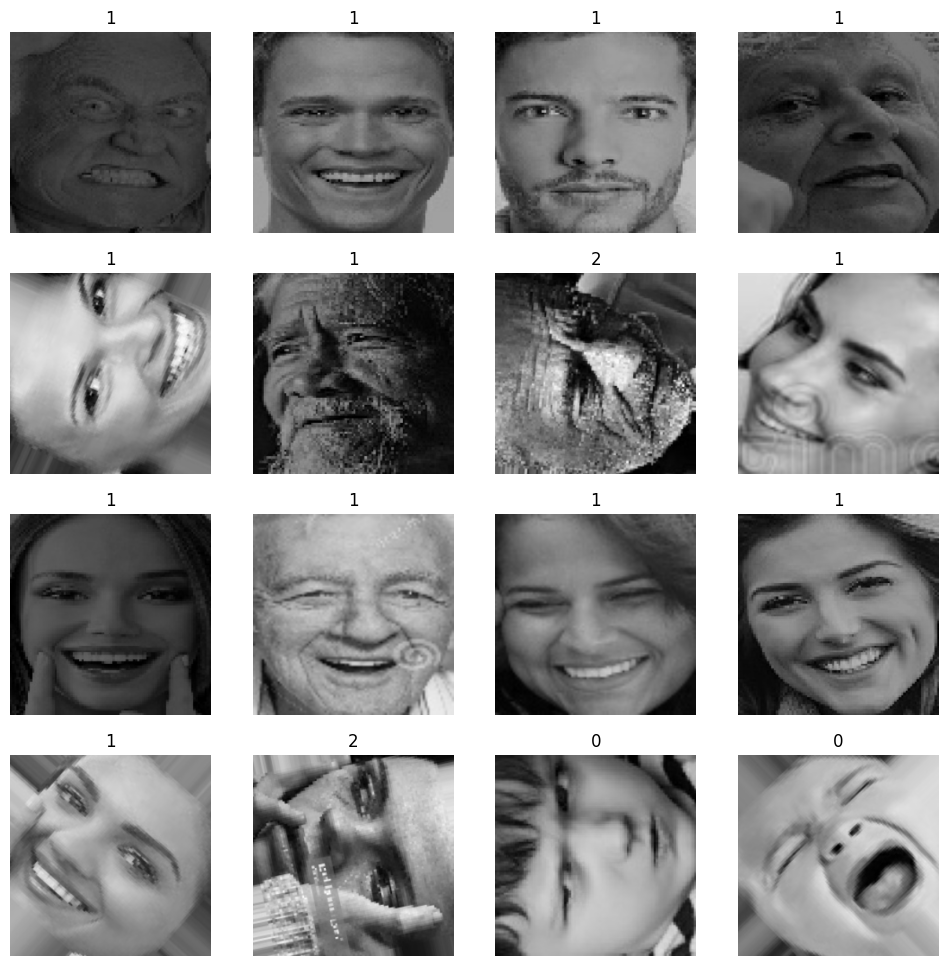

In [75]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title((labels[i]).numpy())
    plt.axis("off")

In [76]:
training_dataset = (
    train_dataset.prefetch(tf.data.AUTOTUNE)
)

In [77]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [78]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    Rescaling(1./255)
])

In [79]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [80]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [81]:
lenet_model_1 = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model_1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_16 (Ba  (None, 254, 254, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 127, 127, 6)       0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 16)     

In [82]:
#loss_function = CategoricalCrossentropy()
loss_function = SparseCategoricalCrossentropy()

In [86]:
metrics = [SparseCategoricalAccuracy()]

In [87]:
lenet_model_1.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [88]:
history = lenet_model_1.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = CONFIGURATION["N_EPOCHS"],
  #epochs = 5,
  verbose = 1,
  #class_weight = class_weights,
  #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
)

Epoch 1/20
213/213 [==============================] - 26s 106ms/step - loss: 0.2076 - sparse_categorical_accuracy: 0.9319 - val_loss: 1.0983 - val_sparse_categorical_accuracy: 0.7054
Epoch 2/20
213/213 [==============================] - 21s 99ms/step - loss: 0.1777 - sparse_categorical_accuracy: 0.9368 - val_loss: 1.2253 - val_sparse_categorical_accuracy: 0.6967
Epoch 3/20
213/213 [==============================] - 20s 95ms/step - loss: 0.1551 - sparse_categorical_accuracy: 0.9422 - val_loss: 5.7643 - val_sparse_categorical_accuracy: 0.3437
Epoch 4/20
213/213 [==============================] - 21s 98ms/step - loss: 0.1507 - sparse_categorical_accuracy: 0.9421 - val_loss: 1.1349 - val_sparse_categorical_accuracy: 0.7278
Epoch 5/20
213/213 [==============================] - 22s 104ms/step - loss: 0.0917 - sparse_categorical_accuracy: 0.9650 - val_loss: 1.0468 - val_sparse_categorical_accuracy: 0.7392
Epoch 6/20
213/213 [==============================] - 21s 98ms/step - loss: 0.2084 - spa

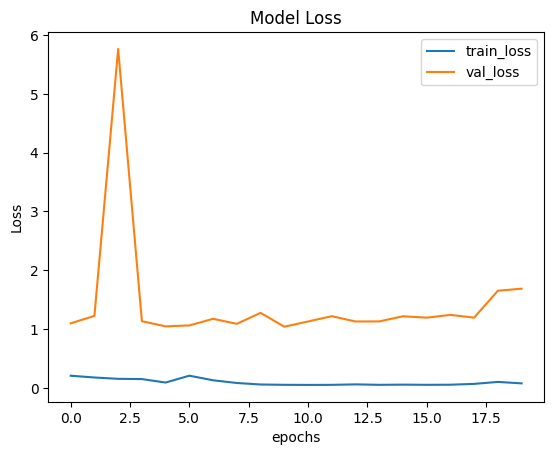

In [89]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("epochs")
plt.legend(["train_loss", "val_loss"])
plt.show()

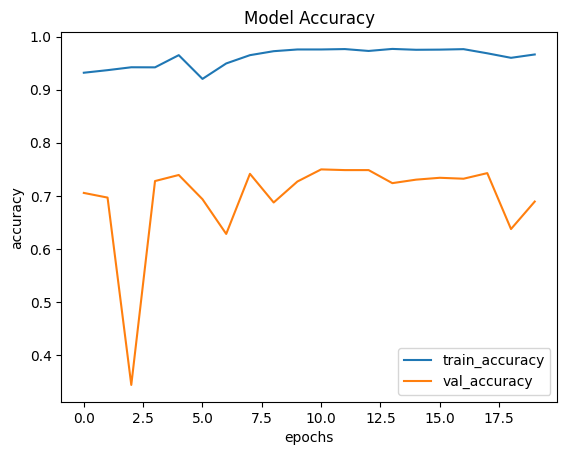

In [91]:
plt.plot(history.history["sparse_categorical_accuracy"])
plt.plot(history.history["val_sparse_categorical_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["train_accuracy", "val_accuracy"])
plt.show()